In [3]:
import sys
import os
import pandas as pd
import numpy as np
import tqdm
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')

import sklearn

import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
torch.cuda.is_available()

True

# 1. Читаем и подготавливаем данные

# Фичи вершин графа и ребра

In [5]:
data_folder = '../homework/'

In [6]:
%%time
df_edges = pd.read_parquet(data_folder + 'df_edges.parquet')

CPU times: total: 12.8 s
Wall time: 4.45 s


In [7]:
%%time
df_nodes = pd.read_parquet(data_folder + 'df_nodes.parquet')

CPU times: total: 1min 19s
Wall time: 45.6 s


In [8]:
df_nodes.head(2)

,node_feature_1,node_feature_2,node_feature_3,node_feature_4,node_feature_5,node_feature_6,node_feature_7,node_feature_8,node_feature_9,node_feature_10,...,node_feature_237,node_feature_238,node_feature_239,node_feature_240,node_feature_241,node_feature_242,node_feature_243,node_feature_244,node_feature_245,index
0,0.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,1.0,...,0.638939,0.891876,0.41435,0.0,0.0,0.083106,0.0,0.429199,0.394773,0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [9]:
# Граф гетерогенный
# Это поле определяет к какой группе относится данная вершина
node_group_col = 'node_feature_1'

In [10]:
del df_nodes['index']

### Определим фичи для каждой группы вершин

In [11]:

a = df_nodes.isnull()#.sum(axis=0)

b = a[df_nodes[node_group_col]==0].sum(axis=0)
features_group0 = b[b==0].index.tolist()
features_group0.remove(node_group_col)

b = a[df_nodes[node_group_col]==1].sum(axis=0)
features_group1 = b[b==0].index.tolist()
features_group1.remove(node_group_col)

del a

In [12]:
print("Число фичей для группы вершин 0:",len(features_group0))
print("Число фичей для группы вершин 1:",len(features_group1))

Число фичей для группы вершин 0: 134
Число фичей для группы вершин 1: 162


In [13]:
# Найдем индексы этих фичей
cols = df_nodes.columns.tolist()
features_idx_group0 = [cols.index(c) for c in features_group0]
features_idx_group1 = [cols.index(c) for c in features_group1]

In [14]:
df_edges.head(2)

,edge_feature_1,edge_feature_2,edge_feature_3,edge_feature_5,edge_feature_7,edge_feature_9,edge_feature_11,edge_feature_12,edge_feature_13,edge_feature_14,...,edge_feature_41,edge_feature_42,edge_feature_43,edge_feature_44,edge_feature_45,edge_feature_46,edge_feature_47,edge_feature_48,index1,index2
0,0.0,1.0,1.436122,3.165249,-1.992887,2.245767,-1.228802,-0.397216,-1.714951,0.829714,...,1.736383,0.960876,0.768179,0.0,2.592106,0.979613,0.351759,0.0,15000,0
1,0.0,1.0,-0.558463,0.047527,-0.993277,-0.591337,-1.228802,-0.581673,-1.714951,0.829714,...,0.000000,0.057755,0.000000,0.0,0.000000,0.427619,0.351759,0.0,15001,0


In [15]:
x = torch.FloatTensor(df_nodes.values)
edge_index = torch.LongTensor(df_edges[['index1','index2']].values).T

del df_edges['index1']
del df_edges['index2']

In [16]:
edge_attr = torch.FloatTensor(df_edges.values)

In [17]:
from torch_geometric.data import Data

# Разберемся с таргетом

In [18]:
df_train = pd.read_csv(data_folder + 'train.csv')
df_test = pd.read_csv(data_folder + 'test.csv')

In [19]:
# 4 бинарных таргета
# доли 1 в каждом тарегте, число 1, размер выборки по таргету
df_train.groupby('label_type').y.agg(['mean','sum','count'])

,mean,sum,count
label_type,,,
label_3,0.039683,10,252
label_4,0.033245,63,1895
label_5,0.055487,180,3244
label_6,0.017566,83,4725


In [20]:
# размер выборки по таргету для test
df_test.label_type.value_counts()

label_6    2327
label_5    1597
label_4     935
label_3     123
Name: label_type, dtype: int64

In [21]:
df_y = df_train.pivot('index','label_type','y')

In [22]:
df_y.head()

label_type,label_3,label_4,label_5,label_6
index,,,,
4,NaN,NaN,NaN,0.0
7,NaN,NaN,NaN,0.0
8,NaN,NaN,NaN,0.0
10,NaN,NaN,0.0,NaN
11,NaN,NaN,0.0,NaN


In [23]:
df_y_ = pd.DataFrame(np.arange(len(x)) , columns=['index'])

In [24]:
df_y = df_y_.merge(df_y.reset_index(), on='index',how='left').set_index('index')

In [25]:
df_y.head()

,label_3,label_4,label_5,label_6
index,,,,
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,0.0


In [26]:
df_y['has_target'] = df_y.notnull().sum(axis=1) > 0

In [27]:
df_y = df_y.fillna(-100)

In [28]:
df_y.head(1)

,label_3,label_4,label_5,label_6,has_target
index,,,,,
0,-100.0,-100.0,-100.0,-100.0,False


In [29]:
node_type = torch.ShortTensor(df_nodes[node_group_col].values)

## make Data OLD

In [ ]:
# Как было
# # 4 таргета
# label_3 = torch.LongTensor(df_y.label_3.values)
# label_4 = torch.LongTensor(df_y.label_4.values)
# label_5 = torch.LongTensor(df_y.label_5.values)
# label_6 = torch.LongTensor(df_y.label_6.values)

# # 
# has_target = torch.BoolTensor(df_y.has_target.values)

# data = Data(x=x, # node features
#             edge_index=edge_index, # edges
#             edge_attr=edge_attr, # edge attributes
#             label_3=label_3,
#             label_4=label_4,
#             label_5=label_5,
#             label_6=label_6,
#             has_target=has_target,# whether node has target
#             node_type=node_type, # 0 or 1st type of node
#             index = torch.arange(len(x))# unique identifier of node
#            )

# Сделаем датасет пригодным для стандартных алгоритов:
# Избавимся от мультитаргета и гетерогенности

### Сольем 4 таргета в 1

In [30]:
df_y.head()

,label_3,label_4,label_5,label_6,has_target
index,,,,,
0,-100.0,-100.0,-100.0,-100.0,False
1,-100.0,-100.0,-100.0,-100.0,False
2,-100.0,-100.0,-100.0,-100.0,False
3,-100.0,-100.0,-100.0,-100.0,False
4,-100.0,-100.0,-100.0,0.0,True


In [31]:
y = df_y[['label_3', 'label_4', 'label_5', 'label_6']].max(axis=1)
y = torch.LongTensor(y.values)

has_target = torch.BoolTensor(df_y.has_target.values)

### Сделаем граф гомогенным: Оставим в графе только веришны группы1

In [32]:
# удалим таргет для вершин группы 0
y[node_type==0] = -100

has_target[node_type==0] = False

In [33]:
# удалим ребра для вершин группы 0
good_e_ids = []
good_nodes = set(torch.nonzero(node_type)[:,0].numpy())
for e_id, e in enumerate(edge_index.T.numpy()):
    if (e[0] in good_nodes) and (e[1] in good_nodes):
        good_e_ids.append(e_id)

In [34]:
edge_index = edge_index[:,good_e_ids]
edge_attr = edge_attr[good_e_ids,:]

In [35]:
x = x[:,features_idx_group1]

In [36]:
del df_nodes
del df_edges
del df_y

In [37]:
data = Data(x=x, # node features
            edge_index=edge_index, # edges
            edge_attr=edge_attr, # edge attributes
            y=y,
            has_target=has_target,# whether node has target
            index = torch.arange(len(x))# unique identifier of node
           )

In [38]:
print('===================================')

print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of edges: {data.edge_index.shape[1]}')
print(f'Number of features: {data.x.shape[1]}')

if data.edge_attr is not None:
    print(f'Number of edge attributes: {data.edge_attr.shape[1]}')


print(f'Number of nodes with target: {int(data.has_target.sum())}')
print('===================================')

Number of nodes: 3356115
Number of edges: 1363644
Number of features: 162
Number of edge attributes: 44
Number of nodes with target: 3960


In [40]:
y = data.y

In [41]:
pd.Series(y[y!=-100]).agg(['mean','sum','count'])

mean        0.029545
sum       117.000000
count    3960.000000
dtype: float64

### 4 FOLDS 

In [42]:
from sklearn.model_selection import StratifiedKFold

In [43]:
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

In [44]:
idx_with_target = torch.nonzero(data.has_target)[:,0].numpy()

In [45]:
# 4 folds
# each fold 75%train indexes and 25%test indexes
kfold_indexes =  [(idx_with_target[tr], idx_with_target[te]) 
                      for tr, te in kfold.split(idx_with_target, data.y[idx_with_target])]

In [46]:
tr, te = kfold_indexes[0]
tr.shape, te.shape

((2970,), (990,))

In [47]:
device = 'cuda'

In [48]:
train_idx, test_idx = kfold_indexes[0]

In [49]:
len(train_idx), len(test_idx)

(2970, 990)

# 2. Обучаем модель

# Train Functions

In [50]:
from torch_geometric.loader import NeighborLoader
def fit_model(data, 
              train_idx, 
              test_idx,
              n_epochs=10, 
              batch_size = 200, 
              lr=0.01,
              weight_decay=1e-3, 
              device=device, 
              model_params={},
              print_metrics=True):
    
    loader_train = NeighborLoader(
        data,
        num_neighbors=[-1, -1],
        batch_size=batch_size,
        shuffle=False,
        input_nodes=train_idx,
    )    
    
    loader_test = NeighborLoader(
        data,
        num_neighbors=[-1, -1],
        batch_size=batch_size,
        shuffle=False,
        input_nodes=test_idx,
    )       
    print('Sample data:',file=sys.stderr)
    loader_train = [c for c in tqdm.tqdm(loader_train)]
    loader_test = [c for c in tqdm.tqdm(loader_test)]
    
    print('Fit model:',file=sys.stderr)
    
    model = GeneralGNN(**model_params)
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)



    # RUN Training 1 model

    for epoch in tqdm.tqdm(range(1, n_epochs+1),disable=True):
        total_loss = train_epoch(model, loader_train, criterion, device, optimizer, tqdm_disable=True)
        if print_metrics:
            df_gnn_score = eval_model(model, loader_train, device, tqdm_disable=True)
            train_auc = roc_auc_score(df_gnn_score.y, df_gnn_score.score)

            df_gnn_score = eval_model(model, loader_test, device, tqdm_disable=True)
            test_auc = roc_auc_score(df_gnn_score.y, df_gnn_score.score)        

            print(f'Epcoh:{epoch:03d} TrainLoss : {total_loss:.3f}, Train AUC : {train_auc:.3f}, Test AUC : {test_auc:.3f}',
              file=sys.stderr)
        

    return model.to('cpu')

In [52]:
def get_cross_val_predict(data, 
                          models,
                          kfold_indexes, 
                          batch_size=200,
                          device=device):
    dfs = []
    for model, (train_idx, test_idx) in zip(models, kfold_indexes):
        loader_test = NeighborLoader(
            data,
            num_neighbors=[-1, -1],
            batch_size=batch_size,
            shuffle=False,
            input_nodes=test_idx,
        )      
        loader_test = [c for c in loader_test]
        df_gnn_score = eval_model(model.to(device), loader_test, device, tqdm_disable=True)
        dfs.append(df_gnn_score)
    return pd.concat(dfs, axis=0)

In [53]:
def train_epoch(model, loader, criterion, device, optimizer, scheduler=None, tqdm_disable=True):
    """
    train model for 1 epoch
    """
    start_time = time.time()

    model.train()
    total_loss = 0

    for data_batch in tqdm.tqdm(loader, leave=False, disable=tqdm_disable):
        sampled_data = data_batch.clone().to(device)

        optimizer.zero_grad()
        out = model(sampled_data)
        loss = criterion(out[:sampled_data.batch_size], sampled_data.y[:sampled_data.batch_size])
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        total_loss += loss.detach().item() / len(loader)

    if scheduler is not None:
        scheduler.step()

    calc_time = time.time() - start_time
    return total_loss

In [54]:
from sklearn.metrics import roc_auc_score
def eval_model(model, loader, device, tqdm_disable=True):
    """
    get prediction
    

    """
    start_time = time.time()
    softmax = torch.nn.Softmax(dim=1)
    
    dfs = []
    
    model.eval()
    with torch.no_grad():
 
        for sampled_data in tqdm.tqdm(loader, leave=False, disable=tqdm_disable):
            sampled_data = sampled_data.clone().to(device)
            out = model(sampled_data)
            outs = {'score': softmax(
                                out[:sampled_data.batch_size].detach()
                            )[:,1].cpu().numpy() 
                   }
            outs['index'] = sampled_data.index[:sampled_data.batch_size].cpu().numpy()
            outs['y'] = sampled_data.y[:sampled_data.batch_size].cpu().numpy()
            dfs.append(pd.DataFrame(outs))
            
    df_gnn_score = pd.concat(dfs,axis=0)
    
    return df_gnn_score

# Model Class

$$\large\mathbf{x}^{\prime}_i = \mathbf{W}_1 \mathbf{x}_i + \mathbf{W}_2 \cdot
\mathrm{mean}_{j \in \mathcal{N(i)}} \mathbf{x}_j$$

То же самое, что GraphSAGE  
Но в реализации GraphConv из Pyg  https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GraphConv.html  
вместо $\mathrm{mean}$ также можно использовать агрегирующие функции $\mathrm{max}$, $\mathrm{add}$

In [55]:
from torch.nn import Linear, ReLU, Sequential, Identity, Dropout, PReLU, Tanh, ELU, LeakyReLU, Sigmoid, GELU
from torch_geometric.nn import GraphConv, SAGEConv

In [57]:
class GeneralGNN(torch.nn.Module):
    def __init__(self,
                 Act = ReLU,
                 ConvClass = GraphConv,
                 input_size = 162,
                 hidden_size1 = 256,
                 conv1_aggrs = {'mean':64, 'max':32, 'add':16},
                 conv2_aggrs = {'mean': 32, 'max':16, 'add':8},
                 dropout_rate = 0.5,
                ):
        super(GeneralGNN, self).__init__()
        torch.manual_seed(420)
        
        self.hidden_size1 = hidden_size1
    
        if self.hidden_size1 != 0:
        
            # preprocces node featrues, reduce to a common dimension
            self.lin_preproc = Linear(input_size, hidden_size1)
            self.activation = Act()
            self.dropout = Dropout(dropout_rate)        

            input_size = hidden_size1
            
        # 1-level convolution with different aggregate functions
        self.conv1 = torch.nn.ModuleDict()
        for aggr, output_size in conv1_aggrs.items():
            self.conv1[aggr] = ConvClass(input_size, output_size, aggr)

        self.conv1_activation = Act()
        self.conv1_dropout = Dropout(dropout_rate)
        
        
        # 2-level convolution with different aggregate functions
        input_size = sum(conv1_aggrs.values())

        self.conv2 = torch.nn.ModuleDict()
        for aggr, output_size in conv2_aggrs.items():
            self.conv2[aggr] = ConvClass(input_size, output_size, aggr)

        self.conv2_activation = Act()
        self.conv2_dropout = Dropout(dropout_rate)
            
        # MAKE PREDICTION FOR EACH TASK
        input_size = sum(conv2_aggrs.values())  
        self.lin_out = Linear(input_size, 2)
        
        
    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        
        if self.hidden_size1 != 0:
            x = self.lin_preproc(x)
            x = self.dropout(self.activation(x))
        
        # concatencate outputs of 1-level convolution with different aggregate functions
        x_out = []
        for conv in self.conv1.values():
            x_out.append(conv(x, edge_index))
        x = torch.cat(x_out, dim=1)
        x = self.conv1_dropout(self.conv1_activation(x))
        
        # concatencate outputs of 2-level convolution with different aggregate functions
        x_out = []
        for conv in self.conv2.values():
            x_out.append(conv(x, edge_index))
        x = torch.cat(x_out, dim=1)
        x = self.conv2_dropout(self.conv2_activation(x))      
            
        out = self.lin_out(x)
        
        return out

In [58]:
GeneralGNN()

GeneralGNN(
  (lin_preproc): Linear(in_features=162, out_features=256, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (conv1): ModuleDict(
    (mean): GraphConv(256, 64)
    (max): GraphConv(256, 32)
    (add): GraphConv(256, 16)
  )
  (conv1_activation): ReLU()
  (conv1_dropout): Dropout(p=0.5, inplace=False)
  (conv2): ModuleDict(
    (mean): GraphConv(112, 32)
    (max): GraphConv(112, 16)
    (add): GraphConv(112, 8)
  )
  (conv2_activation): ReLU()
  (conv2_dropout): Dropout(p=0.5, inplace=False)
  (lin_out): Linear(in_features=56, out_features=2, bias=True)
)

# TRAIN models

In [59]:
models = []
for train_idx, test_idx in kfold_indexes:
    model = fit_model(data, train_idx, test_idx)
    models.append(model)

Sample data:
100%|██████████| 5/5 [00:00<00:00, 10.63it/s]
Fit model:
Epcoh:001 TrainLoss : 0.295, Train AUC : 0.697, Test AUC : 0.659
Epcoh:002 TrainLoss : 0.160, Train AUC : 0.745, Test AUC : 0.702
Epcoh:003 TrainLoss : 0.139, Train AUC : 0.801, Test AUC : 0.714
Epcoh:004 TrainLoss : 0.137, Train AUC : 0.833, Test AUC : 0.727
Epcoh:005 TrainLoss : 0.134, Train AUC : 0.850, Test AUC : 0.734
Epcoh:006 TrainLoss : 0.128, Train AUC : 0.871, Test AUC : 0.732
Epcoh:007 TrainLoss : 0.124, Train AUC : 0.880, Test AUC : 0.738
Epcoh:008 TrainLoss : 0.121, Train AUC : 0.875, Test AUC : 0.753
Epcoh:009 TrainLoss : 0.121, Train AUC : 0.885, Test AUC : 0.743
Epcoh:010 TrainLoss : 0.119, Train AUC : 0.895, Test AUC : 0.728
Sample data:
100%|██████████| 5/5 [00:00<00:00, 88.35it/s]
Fit model:
Epcoh:001 TrainLoss : 0.284, Train AUC : 0.695, Test AUC : 0.697
Epcoh:002 TrainLoss : 0.164, Train AUC : 0.748, Test AUC : 0.743
Epcoh:003 TrainLoss : 0.149, Train AUC : 0.794, Test AUC : 0.761
Epcoh:004 Train

# EVAL: get scores

In [60]:
df_gnn_score = get_cross_val_predict(data, models, kfold_indexes)

In [61]:
df_gnn_score.head()

,score,index,y
0,0.005472,21,0
1,0.156217,59,0
2,0.019122,87,0
3,0.076901,99,0
4,0.002037,104,0


In [62]:
print('Total roc_auc: {:.3f}'.format(roc_auc_score(df_gnn_score.y, df_gnn_score.score)))

Total roc_auc: 0.754


# 3. Атаки

In [63]:
df_gnn_score.groupby('y').score.mean()

y
0    0.027733
1    0.060056
Name: score, dtype: float32

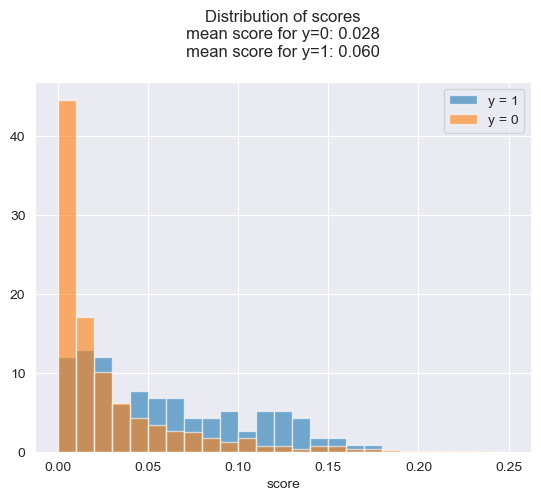

In [64]:
bins = np.linspace(0,0.25,26)
df_gnn_score.loc[df_gnn_score.y == 1,'score'].hist(bins=bins,density=True, alpha=0.6,label='y = 1')
df_gnn_score.loc[df_gnn_score.y == 0,'score'].hist(bins=bins,density=True, alpha=0.6,label='y = 0')
score_mean = df_gnn_score.groupby('y').score.mean()
plt.title(f'''Distribution of scores
mean score for y=0: {score_mean[0]:.3f}
mean score for y=1: {score_mean[1]:.3f}
''')


plt.xlabel('score')
plt.legend();

очевидно, что распределение скоров у вершин разных классов - разное

# 3.1. Эксперименты со случайным удалением и добавлением ребер

In [65]:
df_edges = pd.DataFrame(data.edge_index.T,columns=['index1','index2'])

In [66]:
df_edges.nunique()

index1    1181330
index2     193187
dtype: int64

In [67]:
df_nodes = pd.DataFrame({'index':data.index.numpy(),
                         'has_target':data.has_target.numpy(),
                         'y':data.y.numpy()})
df_nodes = df_nodes[node_type.numpy()==1]

In [68]:
df_nodes['hop0'] = df_nodes['has_target']

In [69]:
hop0_idx = df_nodes.loc[df_nodes['hop0'],'index'].values

In [70]:
hop1_idx = df_edges[df_edges.index2.isin(hop0_idx)].index1.unique()

In [71]:
len(hop0_idx), len(hop1_idx)

(3960, 46102)

In [72]:
df_nodes['hop1'] = df_nodes['index'].isin(hop1_idx) & (~df_nodes['hop0'])

In [73]:
cnt_neighbors = df_edges.groupby('index2').index1.count()

In [74]:
df_nodes['degree'] = df_nodes['index'].map(cnt_neighbors)

In [75]:
df_nodes.head()

,index,has_target,y,hop0,hop1,degree
1,1,False,-100,False,False,6.0
2,2,False,-100,False,False,10.0
4,4,True,0,True,False,11.0
7,7,True,0,True,False,10.0
8,8,True,0,True,False,14.0


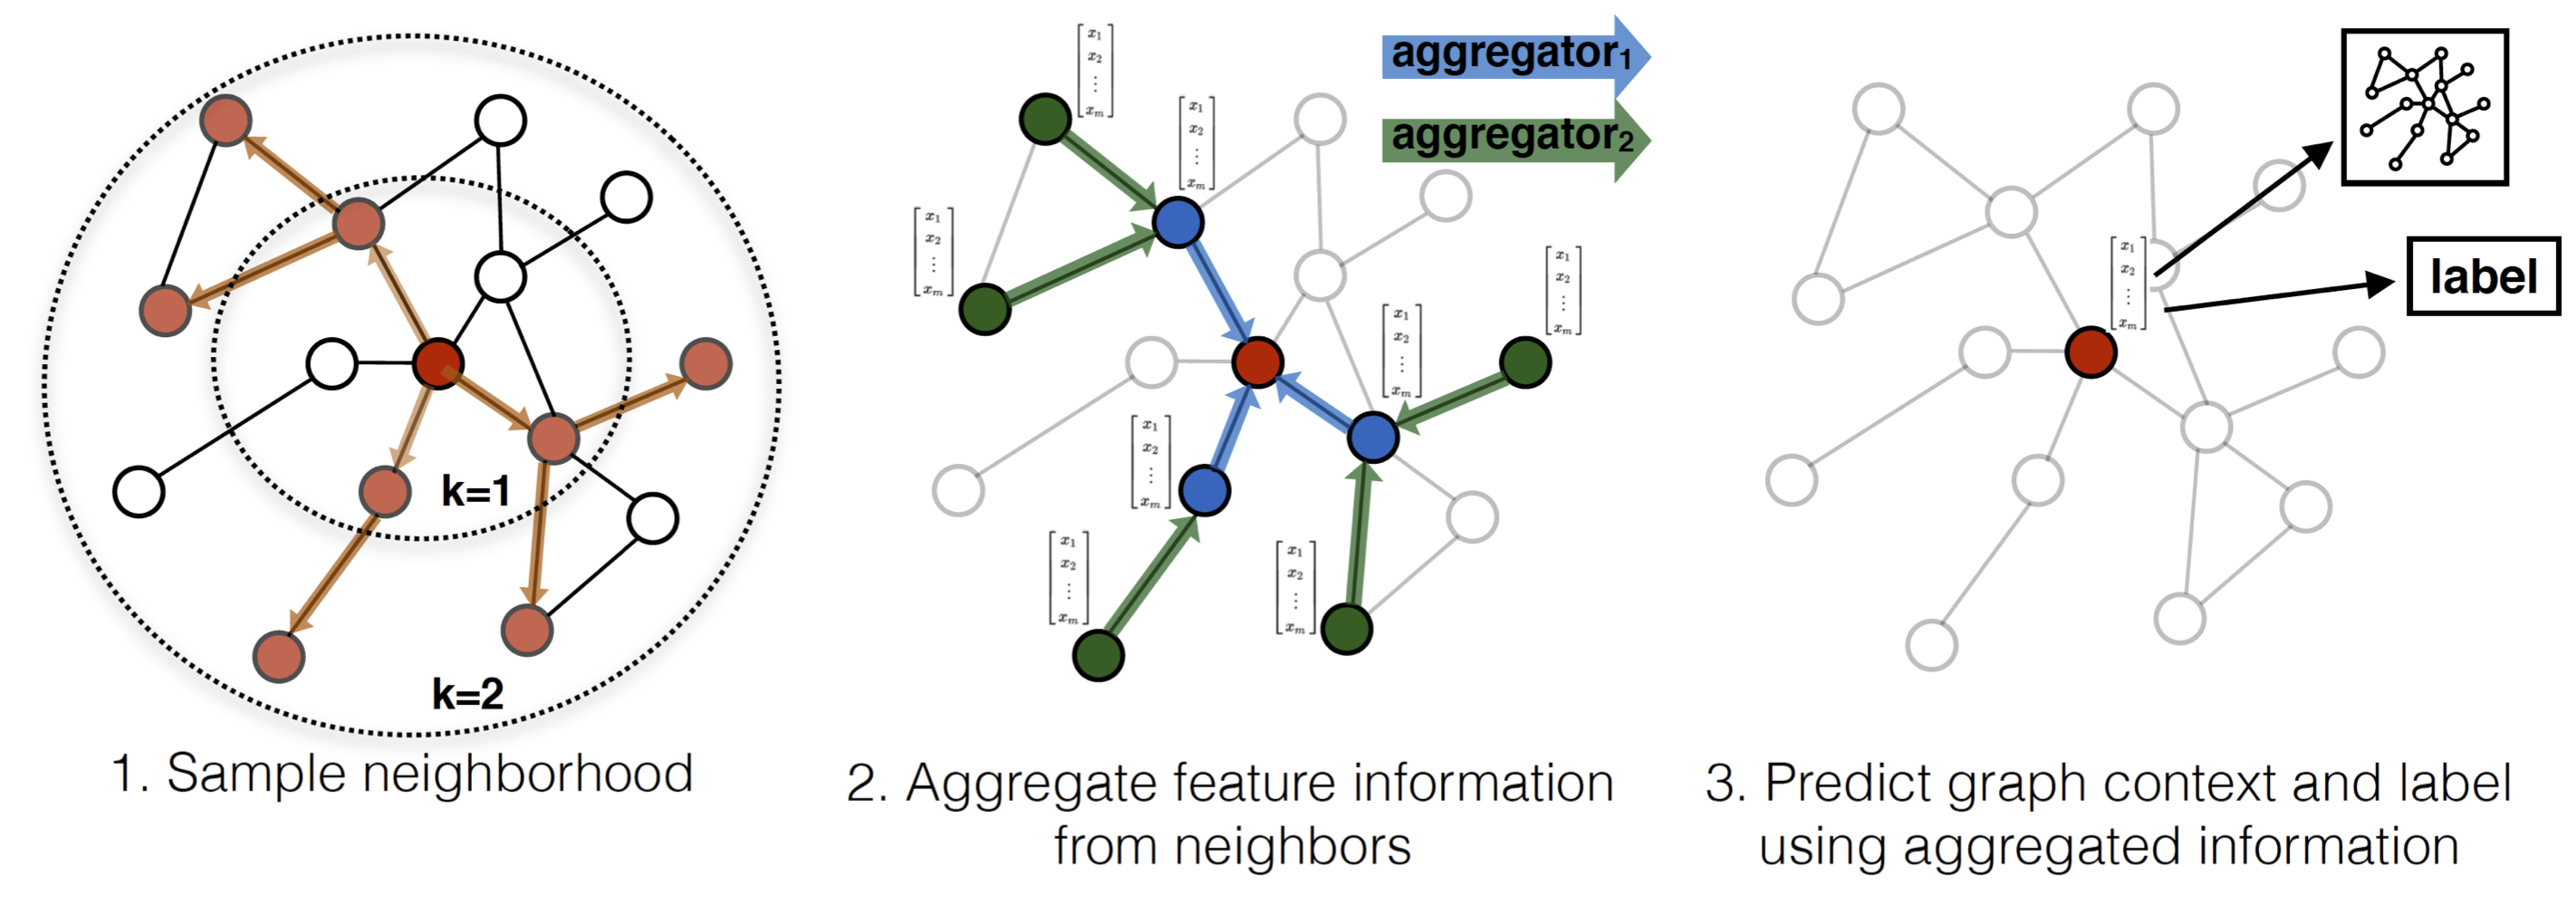

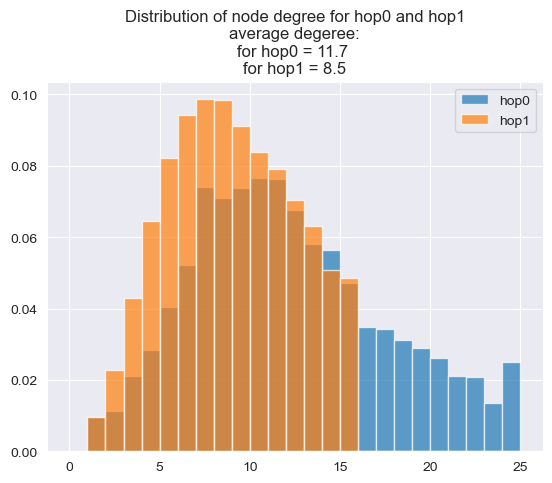

In [76]:
bins = np.linspace(0,25,26)
df_nodes[df_nodes.hop0].degree.hist(bins=bins,density=True,alpha=0.7,label='hop0')
df_nodes[df_nodes.hop1].degree.hist(bins=bins,density=True,alpha=0.7,label='hop1')
plt.legend()
m0 = df_nodes[df_nodes.hop0].degree.mean()
m1 = df_nodes[df_nodes.hop1].degree.mean()
plt.title(f'''Distribution of node degree for hop0 and hop1
average degeree:
for hop0 = {m0:.1f} 
for hop1 = {m1:.1f}'''.format());

# 3.1.1 Удаляем ребра у дефолтных объектов: y=1

In [77]:
def drop_or_add_edges_for_aim_nodes(data, aim_nodes, percent_to_drop = 0.0, percent_to_add = 0.0):
#     assert percent_to_drop + percent_to_add <= 1.01
    
    if percent_to_drop ==0 and percent_to_add ==0:
        return data
    
    df_edges_tmp= pd.DataFrame(data.edge_index.T.numpy(),columns=['index1','index2'])

    df_edges_tmp['aim'] = df_edges_tmp['index2'].isin(aim_nodes)

    
    df_edges_tmp['rnd'] = np.random.rand(len(df_edges_tmp))
    if percent_to_drop != 0:    


        wh_drop = df_edges_tmp.aim & (df_edges_tmp.rnd < percent_to_drop)
        df_edges_tmp = df_edges_tmp.loc[~wh_drop]
        
    if percent_to_add != 0:
        if percent_to_add > 1:
            df_edges_tmp = pd.concat([df_edges_tmp]*int(percent_to_add), axis=0)
        else:
            wh_add = df_edges_tmp.aim & (df_edges_tmp.rnd > 1 - percent_to_add)
            df_edges_tmp = pd.concat([df_edges_tmp, df_edges_tmp[wh_add]], axis=0)
        



    edge_index_changed = torch.LongTensor(df_edges_tmp[['index1','index2']].values.T)

    data_changed = Data(x=data.x, 
         edge_index = edge_index_changed,
         y=data.y, 
         has_target=data.has_target, 
         index=data.index)
    
    return data_changed

In [78]:
import gc

In [79]:
default_nodes = df_nodes[df_nodes.y==1]['index'].values

percent_to_add = 0

aucs = []
score_mean = []
percent_to_drop_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for percent_to_drop in tqdm.tqdm(percent_to_drop_list):
    gc.collect()
    data_changed = drop_or_add_edges_for_aim_nodes(data=data,
                                                   aim_nodes=default_nodes,
                                                   percent_to_drop=percent_to_drop,
                                                   percent_to_add=percent_to_add)
    df_gnn_score_changed = get_cross_val_predict(data_changed, models, kfold_indexes)
    
    aucs.append(roc_auc_score(df_gnn_score_changed.y, df_gnn_score_changed.score))
    score_mean.append(df_gnn_score_changed.loc[df_gnn_score_changed.y==1,'score'].mean())
    
percent_to_drop_list = (np.array(percent_to_drop_list)*100).astype(int)    

100%|██████████| 11/11 [00:33<00:00,  3.01s/it]


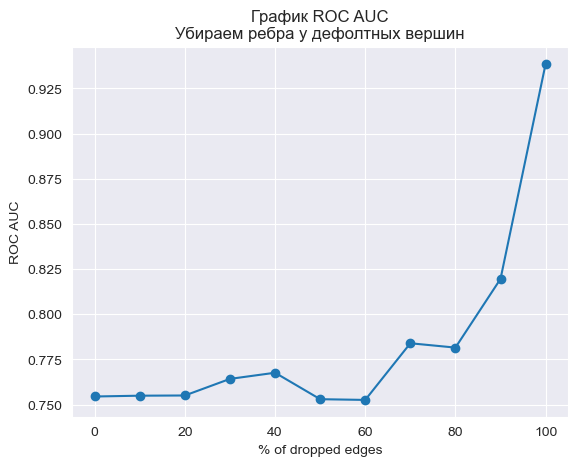

In [80]:
plt.plot(percent_to_drop_list, aucs, marker='o')
plt.xlabel('% of dropped edges')
plt.ylabel('ROC AUC');
plt.title('График ROC AUC\nУбираем ребра у дефолтных вершин');

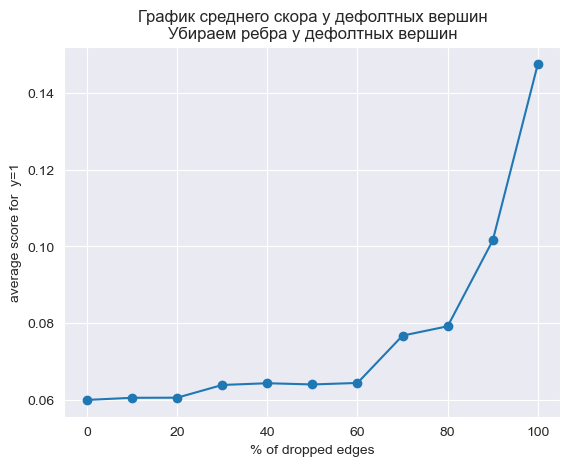

In [81]:
plt.plot(percent_to_drop_list, score_mean, marker='o')
plt.xlabel('% of dropped edges')
plt.ylabel('average score for  y=1');
plt.title('График среднего скора у дефолтных вершин\nУбираем ребра у дефолтных вершин');

# 3.1.2 Удаляем ребра у недефолтных объектов: y=0

In [82]:
not_default_nodes = df_nodes[df_nodes.y==0]['index'].values

percent_to_add = 0

aucs = []
score_mean = []
percent_to_drop_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for percent_to_drop in tqdm.tqdm(percent_to_drop_list):
    gc.collect()
    data_changed = drop_or_add_edges_for_aim_nodes(data=data,
                                                   aim_nodes=not_default_nodes,
                                                   percent_to_drop=percent_to_drop,
                                                   percent_to_add=percent_to_add)
    df_gnn_score_changed = get_cross_val_predict(data_changed, models, kfold_indexes)
    
    aucs.append(roc_auc_score(df_gnn_score_changed.y, df_gnn_score_changed.score))
    score_mean.append(df_gnn_score_changed.loc[df_gnn_score_changed.y==1,'score'].mean())
    
percent_to_drop_list = (np.array(percent_to_drop_list)*100).astype(int)      

100%|██████████| 11/11 [00:24<00:00,  2.20s/it]


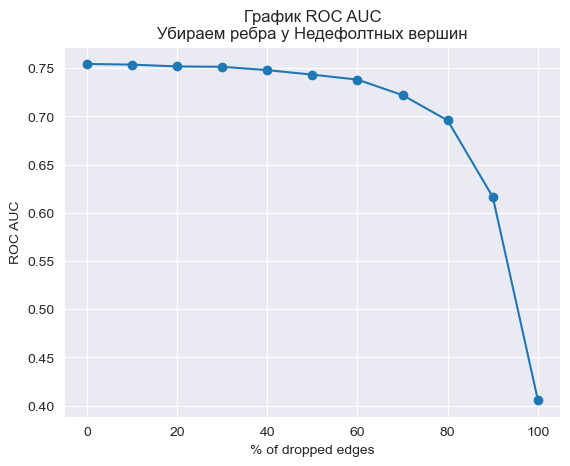

In [83]:
plt.plot(percent_to_drop_list, aucs, marker='o')
plt.xlabel('% of dropped edges')
plt.ylabel('ROC AUC');
plt.title('График ROC AUC\nУбираем ребра у Недефолтных вершин');

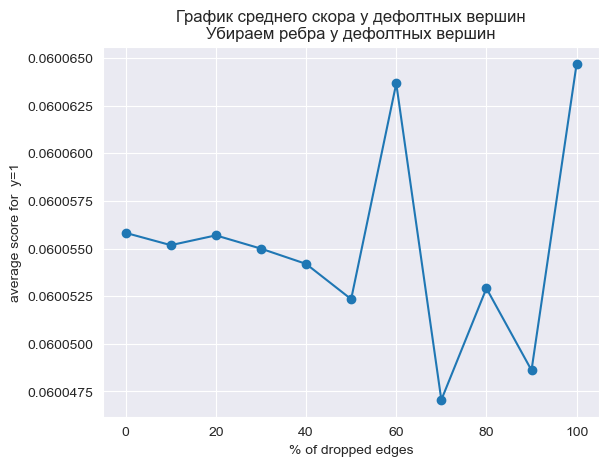

In [84]:
plt.plot(percent_to_drop_list, score_mean, marker='o')
plt.xlabel('% of dropped edges')
plt.ylabel('average score for  y=1');
plt.title('График среднего скора у дефолтных вершин\nУбираем ребра у дефолтных вершин');

Число соседей у вершины влияет на скор

# 3.1.3. Удаляем ребра у всех объектов: y = 0 или 1

In [85]:
all_nodes = df_nodes[df_nodes.has_target]['index'].values

percent_to_add = 0

aucs = []
score_mean = []
percent_to_drop_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for percent_to_drop in tqdm.tqdm(percent_to_drop_list):
    gc.collect()
    data_changed = drop_or_add_edges_for_aim_nodes(data=data,
                                                   aim_nodes=all_nodes,
                                                   percent_to_drop=percent_to_drop,
                                                   percent_to_add=percent_to_add)
    df_gnn_score_changed = get_cross_val_predict(data_changed, models, kfold_indexes)
    
    aucs.append(roc_auc_score(df_gnn_score_changed.y, df_gnn_score_changed.score))
    score_mean.append(df_gnn_score_changed.score.mean())
    
percent_to_drop_list = (np.array(percent_to_drop_list)*100).astype(int)      

100%|██████████| 11/11 [00:22<00:00,  2.08s/it]


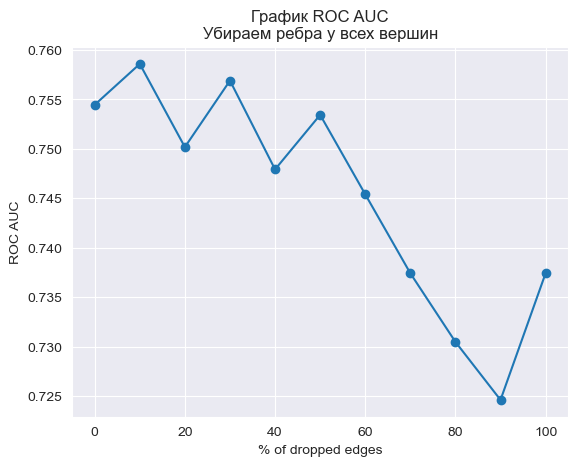

In [86]:
plt.plot(percent_to_drop_list, aucs, marker='o')
plt.xlabel('% of dropped edges')
plt.ylabel('ROC AUC');
plt.title('График ROC AUC\nУбираем ребра у всех вершин');

# 3.1.4 Добавляем ребра у всех объектов: y = 0 или 1

In [90]:
all_nodes = df_nodes[df_nodes.has_target]['index'].values

percent_to_drop = 0

aucs = []
score_mean = []
percent_to_add_list = [0, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
for percent_to_add in tqdm.tqdm(percent_to_add_list):
    gc.collect()
    data_changed = drop_or_add_edges_for_aim_nodes(data=data,
                                                   aim_nodes=not_default_nodes,
                                                   percent_to_drop=percent_to_drop,
                                                   percent_to_add=percent_to_add)
    df_gnn_score_changed = get_cross_val_predict(data_changed, models, kfold_indexes, batch_size=50)
    
    aucs.append(roc_auc_score(df_gnn_score_changed.y, df_gnn_score_changed.score))
    score_mean.append(df_gnn_score_changed.score.mean())
    
percent_to_add_list = (np.array(percent_to_add_list)*100).astype(int)      

100%|██████████| 8/8 [00:28<00:00,  3.51s/it]


In [88]:
del df_gnn_score_changed

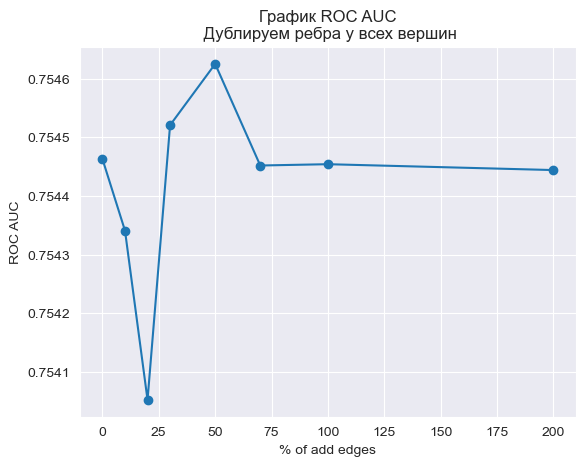

In [89]:
plt.plot(percent_to_add_list, aucs, marker='o')
plt.xlabel('% of add edges')
plt.ylabel('ROC AUC');
plt.title('График ROC AUC\n Дублируем ребра у всех вершин');

качество не сильно поменялось

# 3.2. Более умные атаки

### попытаемся не дублировать имеющиеся ребра, а добавить новые ребра, соеденив между собой нетипичные вершины

### Проскорим все вершины графа
### C помощью GNN проскорить все вершины не получится, нужен подграф глубины 2 для всех вершин, у нас это есть только для вершин с таргетом

### Воспользуемся бустингом

In [91]:
from lightgbm import LGBMClassifier
lgb_params = {'colsample_bytree': 0.8,
         'learning_rate': 0.08,
         'max_depth': 9,
         'n_estimators': 50,
         'min_child_samples':128,
         'num_leaves': 31,
         'reg_alpha': 0,
         'reg_lambda': 1,
         'subsample': 1}

In [ ]:
# # TEST LGB model

# y_test_ = []
# y_pred_  = []
# for i, (train_idx, test_idx) in enumerate(kfold_indexes):
#     X_train = data.x[train_idx,:].numpy()
#     X_test = data.x[test_idx,:].numpy()

#     y_train = data.y[train_idx].numpy()
#     y_test = data.y[test_idx].numpy()
#     lgb_model = LGBMClassifier(**lgb_params, n_jobs=4,verbose=-1)
#     lgb_model.fit(X_train, y_train)
#     y_pred= lgb_model.predict_proba(X_test)[:,1]

#     print('Fold {}: {:.3f}'.format(i, roc_auc_score(y_test, y_pred)))
    
#     y_test_.append(y_test)
#     y_pred_.append(y_pred)    


# print('Total : {:.3f}'.format(roc_auc_score(np.hstack(y_test_), np.hstack(y_pred_))))

In [ ]:
import gc
gc.collect()

### Получим предикт бустинга на все вершины графа (опять же учитываем CV)

In [92]:
dfs = []
for i, (train_idx, test_idx) in tqdm.tqdm(enumerate(kfold_indexes)):
    test_idx = (node_type.numpy() ==1 ) & (~np.isin(data.index.numpy(), train_idx))
    test_idx = np.nonzero(test_idx)[0]
    X_train = data.x[train_idx,:].numpy()
    X_test = data.x[test_idx,:].numpy()

    y_train = data.y[train_idx].numpy()
    y_test = data.y[test_idx].numpy()
    index_test = data.index[test_idx].numpy()
    
    lgb_model = LGBMClassifier(**lgb_params, n_jobs=4,verbose=-1)
    lgb_model.fit(X_train, y_train)
    
    y_pred = lgb_model.predict_proba(X_test)[:,1]
    
    result = pd.DataFrame({'score':y_pred,'index':index_test})

    dfs.append(result)

4it [00:32,  8.24s/it]


In [95]:
df_lgb_score = pd.concat(dfs, axis=0)
df_lgb_score = df_lgb_score.groupby('index',as_index=False).score.mean()

In [96]:
df_nodes = df_nodes.merge(df_gnn_score.drop('y',axis=1), on=['index'], how='left')\
    .merge(df_lgb_score, on=['index'], how='left', suffixes=['_gnn','_lgb'])

In [97]:
df_lgb_score.head()

,index,score
0,1,0.010737
1,2,0.004708
2,4,0.028871
3,7,0.036210
4,8,0.017361


In [98]:
a = df_lgb_score.merge(df_gnn_score,on='index',suffixes=['_lgb','_gnn'])
roc_auc_score(a.y, a.score_lgb), roc_auc_score(a.y, a.score_gnn), roc_auc_score(a.y, a.score_lgb+a.score_gnn)


(0.7632391894686977, 0.7544631041898802, 0.7761520001957161)

## План атаки:
## 1. Отбираем “плохие” вершины cо score > 0.1 
## 2. Добавляем к ним связи с “хорошими” вершинами score< 0.005

In [102]:
df_nodes.has_target & (df_nodes.score_gnn.fillna(0) > 0.1)

TypeError: '<' not supported between instances of 'str' and 'int'

In [107]:
df_nodes.columns

Index(['index', 'has_target', 'y', 'hop0', 'hop1', 'degree', 'score_gnn',
       'score_lgb', 'score_gnn', 'score_lgb'],
      dtype='object')

In [110]:
del df_nodes.iloc[:,-2]

AttributeError: __delitem__

In [111]:
# для атаки выбираем вершины с таргетом где score > 0.1
indexes_to_attack = df_nodes.loc[df_nodes.has_target & (df_nodes.iloc[:,-2] > 0.1),'index'].values


In [114]:
# в качестве хороших вершин выбираем вершины со скором < 0.005 и имеющие соседей
good_indexes = df_nodes.loc[(df_nodes.hop0 | df_nodes.hop1) & (df_nodes.iloc[:,-1] < 0.005),'index'].values

In [115]:
len(indexes_to_attack), len(good_indexes)

(275, 10711)

In [116]:
%%time
df_total_list = []
for ADD_N_EDGES in [0, 1, 2, 3, 5, 7, 10, 15, 20, 25]:
    gc.collect()
    print(f'ADD_N_EDGES = {ADD_N_EDGES}')
    index2_list = list(indexes_to_attack) * ADD_N_EDGES
    good_indexes_rnd = list(np.random.choice(good_indexes, size=len(index2_list)))
    # добавляем ребра от хороших к плохим и обратно
    extra_edges = np.vstack([good_indexes_rnd+index2_list,index2_list+good_indexes_rnd])

    extra_edges = torch.LongTensor(extra_edges)

#     # edge_index_orignal = data.edge_index
#     assert edge_index_orignal.shape[1] == df_edges.shape[0]

    edge_index_changed = torch.hstack([data.edge_index,extra_edges])
    
    data_changed = Data(x=data.x, 
         edge_index = edge_index_changed,
         y=data.y, 
         has_target=data.has_target, 
         index=data.index)
    
    df_gnn_score_changed = get_cross_val_predict(data_changed, models, kfold_indexes)

    #assert data.edge_index.shape !=edge_index_orignal.shape
    

 
    df_gnn_score_changed['ADD_N_EDGES'] = ADD_N_EDGES
    df_total_list.append(df_gnn_score_changed)

ADD_N_EDGES = 0
ADD_N_EDGES = 1
ADD_N_EDGES = 2
ADD_N_EDGES = 3
ADD_N_EDGES = 5
ADD_N_EDGES = 7
ADD_N_EDGES = 10
ADD_N_EDGES = 15
ADD_N_EDGES = 20
ADD_N_EDGES = 25
CPU times: total: 1min 44s
Wall time: 31.9 s


In [117]:
df_all_scores = pd.concat(df_total_list,axis=0)

In [118]:
df_all_scores.head(2)

,score,index,y,ADD_N_EDGES
0,0.005472,21,0,0
1,0.156217,59,0,0


In [121]:
df_score_mean = df_all_scores[df_all_scores['index'].isin(indexes_to_attack)].groupby('ADD_N_EDGES').score.mean()

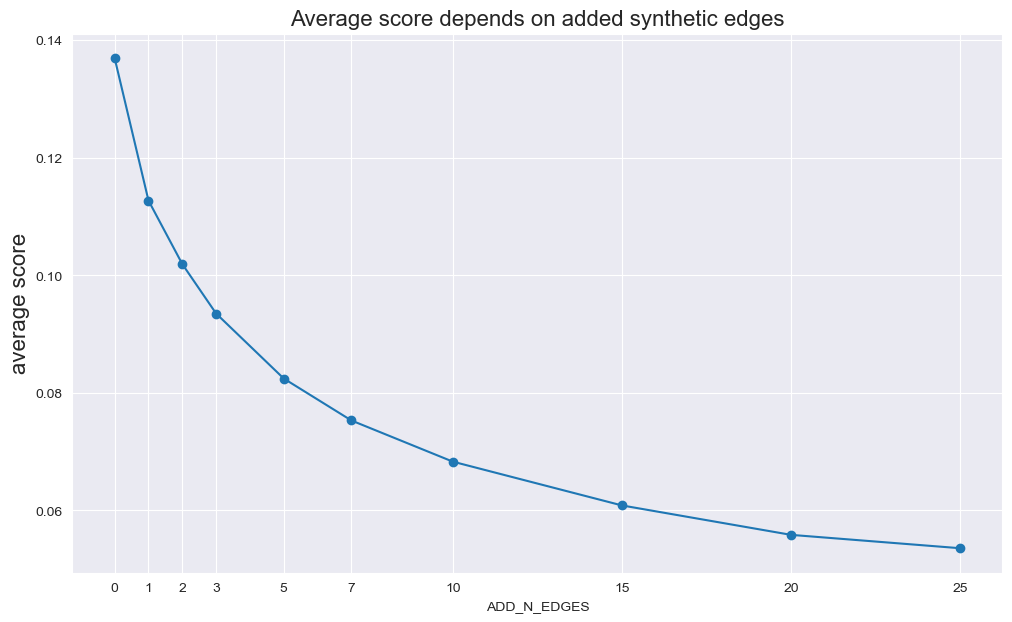

In [122]:
df_score_mean.plot(marker='o', figsize=(12,7))
plt.xticks(df_score_mean.index);
plt.ylabel('average score',fontsize=16);
plt.title('Average score depends on added synthetic edges',fontsize=16);

In [123]:
ADD_N_EDGES = 5
df_score_attacked = df_all_scores[df_all_scores['index'].isin(indexes_to_attack) & (df_all_scores.ADD_N_EDGES==ADD_N_EDGES)]

In [124]:
df = df_gnn_score.merge(df_score_attacked.drop('y',axis=1),on=['index'], suffixes=['_orig','_attacked'])

In [125]:
df.head(2)

,score_orig,index,y,score_attacked,ADD_N_EDGES
0,0.156217,59,0,0.103055,5
1,0.109649,105,0,0.078682,5


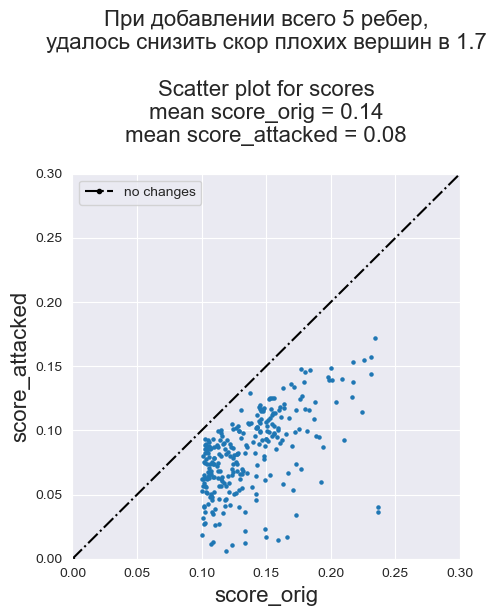

In [126]:
plt.figure(figsize=(5,5))
plt.scatter(df['score_orig'], df['score_attacked'], s=5)
plt.xlim(0,0.3)
plt.ylim(0,0.3)
plt.plot([0,0.6],[0,0.6],'.-.',c='black', label='no changes')
plt.xlabel('score_orig', fontsize=16)
plt.ylabel('score_attacked', fontsize=16);
plt.legend();
a = df[['score_orig','score_attacked']].mean().to_dict()
plt.title(f'''При добавлении всего {ADD_N_EDGES} ребер,
удалось снизить скор плохих вершин в {a['score_orig']/a['score_attacked']:.1f}

Scatter plot for scores
mean score_orig = {a['score_orig']:.2f}
mean score_attacked = {a['score_attacked']:.2f}
''', fontsize=16);

In [ ]:
df['score_orig'], df['score_attacked']

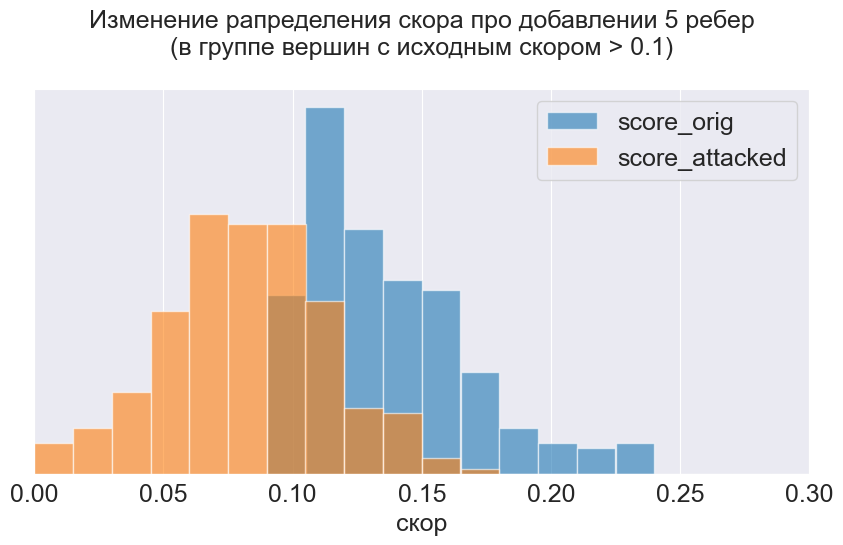

In [127]:
fontsize = 18
orig_name = 'score_orig'
mod_name = 'score_attacked'

bins = np.linspace(0,0.3,num=21)

plt.figure(figsize=(10,5))

df[orig_name].hist(bins=bins, label=orig_name, alpha=0.6, density=True)
df[mod_name].hist(bins=bins, label=mod_name, alpha=0.6, density=True)
plt.legend(fontsize=fontsize)
plt.xlim(0,0.3);
plt.xticks(fontsize=fontsize);
plt.yticks(ticks = []);
plt.xlabel('скор', fontsize=fontsize);

reber= 'ребер' if ADD_N_EDGES !=1 else 'ребра'
plt.title(
f"""Изменение рапределения скора про добавлении {ADD_N_EDGES} {reber}
(в группе вершин с исходным скором > 0.1)
""",fontsize=fontsize);

# 4. Воспользуемся поиском аномалий для определения атак

In [128]:
gc.collect()

7548

In [129]:
len(indexes_to_attack)

275

In [130]:
indexes_with_target = data_changed.index[data_changed.has_target].numpy()
len(indexes_with_target)

3960

In [131]:
good_indexes = indexes_with_target#np.random.choice(indexes_with_target,size=3000)

# y = np.hstack([[1]*len(indexes_to_attack), [0]*len(good_indexes)])

y = torch.zeros_like(data.y)
y[indexes_to_attack] = 1

data_changed.y = y

In [132]:
input_nodes = np.hstack([indexes_to_attack, good_indexes])

In [133]:
loader = NeighborLoader(
    data_changed,
    num_neighbors=[-1],
    batch_size=200,
    shuffle=True,
    input_nodes=input_nodes,
) 

In [134]:
subsample_data = next(iter(loader))

In [135]:
subsample_data = Data(x=subsample_data.x,
                      edge_index=subsample_data.edge_index,
                      y=subsample_data.y,
                     has_target=subsample_data.has_target)

In [136]:
gpu = 0 

In [137]:
def print_roc_auc(data, score):
    y = data.y.numpy()[data.has_target]
    if not isinstance(score,np.ndarray):
        score = score.numpy()
    score = score[data.has_target]
    print('ROC AUC = {:.3f}'.format(roc_auc_score(y, score)))

In [141]:
%%time
from pygod.detector import AnomalyDAE

model = AnomalyDAE(num_layers=4, backbone=GraphConv)
model.fit(subsample_data)
score = model.decision_score_.numpy()
print('AnomalyDAE')
print_roc_auc(subsample_data, score)

AnomalyDAE
ROC AUC = 0.580
CPU times: total: 7.53 s
Wall time: 2.05 s


In [142]:
%%time
from pygod.detector import CONAD

model = CONAD(num_layers=2,gpu=gpu, backbone=GraphConv)
model.fit(subsample_data)
score = model.decision_score_.numpy()
print('CONAD')
print_roc_auc(subsample_data, score)

CONAD
ROC AUC = 0.551
CPU times: total: 50.3 s
Wall time: 13.6 s


In [143]:
%%time
from pygod.detector import DOMINANT

model = DOMINANT(num_layers=2,gpu=gpu, backbone=GraphConv)
model.fit(subsample_data)
score = model.decision_score_.numpy()
print('DOMINANT')
print_roc_auc(subsample_data, score)

DOMINANT
ROC AUC = 0.543
CPU times: total: 24 s
Wall time: 6.67 s


In [144]:
%%time
from pygod.detector import GAE

model = GAE(gpu=gpu, num_layers=2, backbone=GraphConv)
model.fit(data)
score = model.decision_score_.numpy()
y =data.y.bool().numpy().astype(int)
print('GAE')
print_roc_auc(data, score)

RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 2174762520 bytes.

# 5. Способы защиты от атак
https://github.com/DSE-MSU/DeepRobust/tree/master